# Clasificador **Andrés vs Fondo** con VGG-16

**Objetivo:** Entrenar un clasificador binario con **VGG-16** para distinguir entre:
- **Andres** (rostro del estudiante)
- **Fondo** (otras personas y escenas)

In [1]:
import os, cv2, json, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# TensorFlow para usar todos los núcleos del Ryzen 7 4700U
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count() or 8)
os.environ["TF_NUM_INTRAOP_THREADS"] = os.environ["OMP_NUM_THREADS"]
os.environ["TF_NUM_INTEROP_THREADS"] = os.environ["OMP_NUM_THREADS"]

import tensorflow as tf
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

# Configuración de hilos
tf.config.threading.set_intra_op_parallelism_threads(int(os.environ["OMP_NUM_THREADS"]))
tf.config.threading.set_inter_op_parallelism_threads(max(1, (int(os.environ["OMP_NUM_THREADS"]) // 2)))

# Directorios base
BASE = Path(r"D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05")
DS   = BASE / "dataset"
IMG_SIZE = (224, 224)
CLASS_MAP = {"Fondo":0, "Andres":1}   # 0 = Fondo, 1 = Andres

In [2]:
# Carga de imágenes del dataset (entrenamiento, validación, test)
def load_images(folder: Path):
    images, labels = [], []
    folder_name = folder.name  # 'Andres' o 'Fondo'
    y = CLASS_MAP.get(folder_name, 0)
    for fname in os.listdir(folder):
        p = folder / fname
        img = cv2.imread(str(p))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = preprocess_input(img.astype(np.float32))
        images.append(img)
        labels.append(y)
    return images, labels

def load_split(split_name: str):
    X, y = [], []
    for cls in ("Andres", "Fondo"):
        Xi, yi = load_images(DS / split_name / cls)
        X += Xi; y += yi
    X = np.array(X, dtype=np.float32)
    y = to_categorical(np.array(y, dtype=np.int32), num_classes=2)
    return X, y

X_train, y_train = load_split("train")
X_val,   y_val   = load_split("val")
X_test,  y_test  = load_split("test")

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

Train: (1130, 224, 224, 3) (1130, 2)
Val:   (305, 224, 224, 3) (305, 2)
Test:  (242, 224, 224, 3) (242, 2)


In [3]:
# Definición del modelo VGG-16 (transfer learning)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

ckpt_path = BASE / "models" / "vgg16_andres_vs_fondo.keras"
ckpt_path.parent.mkdir(parents=True, exist_ok=True)
checkpoint = ModelCheckpoint(str(ckpt_path), monitor='val_loss', save_best_only=True, verbose=0)

baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # 2 clases: 0=Fondo, 1=Andres

for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [4]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_on_plateau, checkpoint],
    verbose=1
)

Epoch 1/50


36/36 [==============================] - 114s 3s/step - loss: 0.9506 - accuracy: 0.9558 - val_loss: 0.0319 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - 108s 3s/step - loss: 0.2704 - accuracy: 0.9912 - val_loss: 0.2752 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - 111s 3s/step - loss: 0.4066 - accuracy: 0.9920 - val_loss: 0.1563 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 4/50
36/36 [==============================] - 110s 3s/step - loss: 0.1271 - accuracy: 0.9956 - val_loss: 0.3862 - val_accuracy: 0.9803 - lr: 5.0000e-04
Epoch 5/50
36/36 [==============================] - 122s 3s/step - loss: 0.0150 - accuracy: 0.9991 - val_loss: 0.1240 - val_accuracy: 0.9902 - lr: 5.0000e-04
Epoch 6/50
36/36 [==============================] - 118s 3s/step - loss: 0.0080 - accuracy: 0.9991 - val_loss: 0.3804 - val_accuracy: 0.9803 - lr: 2.5000e-04


In [5]:
# Evaluación final en el conjunto de prueba
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test — Loss: {loss:.4f}  |  Accuracy: {acc:.4f}")

y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nMatriz de confusión (filas=verdadero, columnas=predicho):")
print(confusion_matrix(y_true, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=["Fondo","Andres"]))

Test — Loss: 0.5208  |  Accuracy: 0.9711

Matriz de confusión (filas=verdadero, columnas=predicho):
[[102   1]
 [  6 133]]

Reporte de clasificación:
              precision    recall  f1-score   support

       Fondo       0.94      0.99      0.97       103
      Andres       0.99      0.96      0.97       139

    accuracy                           0.97       242
   macro avg       0.97      0.97      0.97       242
weighted avg       0.97      0.97      0.97       242



In [6]:
# Guardado (modelo y etiquetas)
labels_json = BASE / "labels_andres_vs_fondo.json"
with open(labels_json, "w", encoding="utf-8") as f:
    json.dump({v:k for k,v in CLASS_MAP.items()}, f, ensure_ascii=False, indent=2)

print("Modelo guardado en:", ckpt_path)
print("Etiquetas guardadas en:", labels_json)


Modelo guardado en: D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05\models\vgg16_andres_vs_fondo.keras
Etiquetas guardadas en: D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05\labels_andres_vs_fondo.json


In [10]:
# Función de predicción

from mtcnn.mtcnn import MTCNN

NEW_IMAGES_DIR = BASE / "new_images"
NEW_IMAGES_DIR.mkdir(exist_ok=True)
detector = MTCNN()

def crop_with_margin(img, box, pad=0.25, size=224):
    x, y, w, h = box
    H, W = img.shape[:2]
    cx, cy = x + w/2, y + h/2
    s = int(max(w, h) * (1 + pad))
    x1 = max(0, int(cx - s/2)); y1 = max(0, int(cy - s/2))
    x2 = min(W, int(cx + s/2)); y2 = min(H, int(cy + s/2))
    crop = img[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    return cv2.resize(crop, (size, size), interpolation=cv2.INTER_AREA)

def preprocess_face(path):
    """Detecta el rostro más grande en la imagen y devuelve el crop."""
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"No se pudo leer la imagen: {path}")
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(rgb)
    if not faces:
        raise ValueError(f"No se detectó rostro en la imagen: {path}")
    # rostro más grande
    f = max(faces, key=lambda d: d["box"][2]*d["box"][3])
    crop = crop_with_margin(rgb, f["box"])
    return crop

def predict_image(filename_or_path, model, show=True):
    """
    Realiza predicción individual.
    Busca en:
      - dataset/test/{Andres,Fondo}
      - new_images/
    Aplica detección facial antes de predecir.
    """
    name = Path(filename_or_path).name
    if not Path(filename_or_path).exists():
        for sub in ["test/Andres", "test/Fondo", "new_images"]:
            p = BASE / "dataset" / sub / name if "test" in sub else BASE / sub / name
            if p.exists():
                filename_or_path = p
                break

    path = Path(filename_or_path)
    if not path.exists():
        raise FileNotFoundError(f"No se encontró la imagen: {path}")

    try:
        face = preprocess_face(path)
    except Exception as e:
        print(f"[WARN] {e}")
        return None

    x = preprocess_input(face.astype(np.float32))
    x = np.expand_dims(x, 0)
    p = model.predict(x, verbose=0)[0]  # [p_fondo, p_andres]
    label_idx = int(np.argmax(p))
    label = {0:"Fondo",1:"Andres"}[label_idx]

    if show:
        plt.imshow(face.astype(np.uint8))
        plt.title(f"{label}  (p_Andres={p[1]:.3f}, p_Fondo={p[0]:.3f})")
        plt.axis('off')
        plt.show()

    print(f"Predicción → {label} | p(Andres)={p[1]:.4f} | p(Fondo)={p[0]:.4f}")
    print(f"Archivo: {path}")
    return label


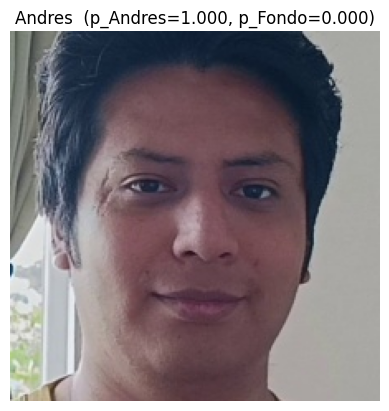

Predicción → Andres | p(Andres)=1.0000 | p(Fondo)=0.0000
Archivo: D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05\dataset\test\Andres\andres_VID_20251022_160012_0017.jpg


'Andres'

In [11]:
# Imagen del conjunto de test
predict_image("andres_VID_20251022_160012_0017.jpg", model)

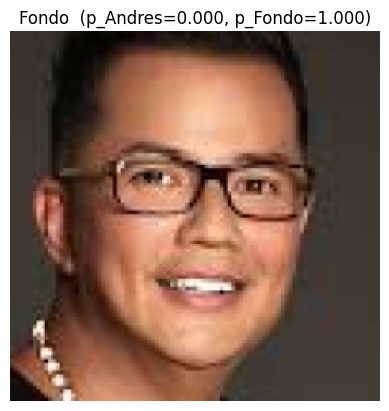

Predicción → Fondo | p(Andres)=0.0000 | p(Fondo)=1.0000
Archivo: D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05\new_images\prueba_1.jpg


'Fondo'

In [12]:
predict_image("prueba_1.jpg", model)